<img src="images/ScDo-Bandeau_Lingua_Technologies.png" style="width: 100%;float:center;"/>

<h2 style="font-size:200%;text-align:center">Petit exercice d'exploration de données</h2>
<h2 style="font-size:200%;text-align:center">avec Pandas</h2>
<h1 style="font-size:250%;text-align:center">Évolution de la pandémie du COVID-19</h1>
<h4 style="font-size:150%;text-align:center">par Claude COULOMBE</h4>
<h5 style="font-size:100%;text-align:center">PhD, scientifique de données, consultant Lingua Technologies</h5>


<img src="images/ScDo-pandas_logo.png" width=400 />

### Importation des bibliothèques utilisées

In [35]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline


## Données

### Dépôt de données ouvertes du COVID-19 - Johns Hopkins University


https://github.com/CSSEGISandData/COVID-19

<img src="" style="width: 100%;float:center;"/>

**Note** : Les données contenues dans le répertoire DATA doivent être mise à jour régulièrement pour refléter l'évolution de la pandémie dans le temps. Pour le moment les données s'arrêtent au jeudi 12 mars 2020.


### Lecture des données

Nous nous intéressons au fichier `time_series_19-covid-Confirmed.csv` qui contient les données sur les cas confirmés de COVID-19

In [36]:
# Note - bonne pratique de postfixer les Dataframe par _df (Rappel: Python n'est pas typé)
series_chronologiques_COVID19_df = pd.read_csv('DATA/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',sep=',')


## Exploration des données

In [37]:
series_chronologiques_COVID19_df.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,43,47,48,50,50,50,53,59,70
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,293,331,360,420,461,502,511,581,639,639
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,110,110,117,130,138,150,150,160,178,178
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,36,50,50,83,93,99,117,129,149,149


In [38]:
series_chronologiques_COVID19_df.tail()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
401,"Oakland, MI",US,42.5922,-83.3362,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
402,"Wayne, MI",US,42.2791,-83.3362,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
403,"New Castle, DE",US,39.5393,-75.6674,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
404,NaN,Cuba,22.0000,-80.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
405,NaN,Guyana,5.0000,-58.7500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Afficher les propriétés globales du tableau de données / DataFrame

Sa forme, les structures de données sous-jacentes et une description statistiques des variables numériques

In [39]:
series_chronologiques_COVID19_df.shape


(406, 55)

In [40]:
series_chronologiques_COVID19_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20'],
      dtype='object')

In [41]:
series_chronologiques_COVID19_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 55 columns):
Province/State    298 non-null object
Country/Region    406 non-null object
Lat               406 non-null float64
Long              406 non-null float64
1/22/20           406 non-null int64
1/23/20           406 non-null int64
1/24/20           406 non-null int64
1/25/20           406 non-null int64
1/26/20           406 non-null int64
1/27/20           406 non-null int64
1/28/20           406 non-null int64
1/29/20           406 non-null int64
1/30/20           406 non-null int64
1/31/20           406 non-null int64
2/1/20            406 non-null int64
2/2/20            406 non-null int64
2/3/20            406 non-null int64
2/4/20            406 non-null int64
2/5/20            406 non-null int64
2/6/20            406 non-null int64
2/7/20            406 non-null int64
2/8/20            406 non-null int64
2/9/20            406 non-null int64
2/10/20           406 non-null int64
2

In [42]:
series_chronologiques_COVID19_df.describe()


,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,...,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,34.230418,-39.800212,1.366995,1.608374,2.317734,3.532020,5.216749,7.209360,13.738916,15.187192,...,228.669951,234.285714,241.088670,250.699507,260.642857,270.431034,279.706897,292.098522,310.012315,316.115764
std,16.728231,81.517075,22.088504,22.176883,27.621070,38.455781,53.754654,72.435194,177.581700,178.723538,...,3350.561669,3359.988841,3371.607924,3385.869130,3400.227670,3413.844250,3429.899066,3443.224924,3470.631220,3478.849642
min,-41.454500,-157.858400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.353175,-95.909325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.687450,-77.063950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,42.399500,17.259325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,3.000000,4.000000,5.000000,7.750000,9.000000,12.000000,17.750000,19.000000
max,64.963100,174.886000,444.000000,444.000000,549.000000,761.000000,1058.000000,1423.000000,3554.000000,3554.000000,...,67217.000000,67332.000000,67466.000000,67592.000000,67666.000000,67707.000000,67743.000000,67760.000000,67773.000000,67781.000000


### Examen de la distribution des données et des attributs

In [43]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.api.types import is_string_dtype, is_numeric_dtype 

NBR_MAX_ATTRIBUTS_AFFICHES = 53

# Pour chaque attribut ou colonne d'un tableau de données / DataFrame
# Créer une boîte à moustaches, un hitogramme ou une listes de valeurs possibles

def examen_distributions_attributs(un_dataframe):
    for attribut in un_dataframe.columns:
        # Afficher le type d'attribut
        print("-"*90)
        print("Attribut:",attribut,", Type:",un_dataframe.dtypes[attribut])
        # Si c'est un attribut catégoriel alors lister toutes les valeurs possibles
        if is_string_dtype(un_dataframe[attribut]):
            attributs_uniques = list(un_dataframe[attribut].unique())
            print("Nombre d'attributs_uniques:",len(attributs_uniques))
            if len(attributs_uniques) > NBR_MAX_ATTRIBUTS_AFFICHES:
                print("Affichage des " + str(NBR_MAX_ATTRIBUTS_AFFICHES) + " premières valeurs:")
                print(attributs_uniques[:NBR_MAX_ATTRIBUTS_AFFICHES])
            else:
                print(attributs_uniques)
                print("\nun_dataframe.groupby('"+attribut+"').size()\n",un_dataframe.groupby(attribut).size())
        if is_numeric_dtype(un_dataframe[attribut]):
            _ = un_dataframe.boxplot(attribut, figsize=(2, 3))
            plt.show()
            print()
            plt.close()
            _ = un_dataframe[attribut].plot(kind='hist',figsize=(2, 3))
            plt.show()
    print("-"*90)

In [ ]:
examen_distributions_attributs(series_chronologiques_COVID19_df)

### Retrait d'attributs «superflus»

Puisque nous nous intéressons à l'évolution du nombre de malades dans le temps, certains attributs (colonnes du tableau de données) sont superflus ou «inutiles» et alourdissent notre analyse.

Ci-dessous une liste d'attributs à retirer:

In [47]:
attributs_a_retirer = ["Lat","Long"]


Retirer les attributs «superflus» avec la fonction `.drop()`

In [48]:
series_chronologiques_COVID19_df = series_chronologiques_COVID19_df.drop(attributs_a_retirer,axis='columns')


In [49]:
series_chronologiques_COVID19_df.head()


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
0,NaN,Thailand,2,3,5,7,8,8,14,14,...,43,43,47,48,50,50,50,53,59,70
1,NaN,Japan,2,1,2,2,4,4,7,7,...,293,331,360,420,461,502,511,581,639,639
2,NaN,Singapore,0,1,3,3,4,5,7,7,...,110,110,117,130,138,150,150,160,178,178
3,NaN,Nepal,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,0,0,0,3,4,4,4,7,...,36,50,50,83,93,99,117,129,149,149


### Modification du format des dates

Pour l'affichage de date selon la norme des pays francophones.

In [50]:
new_columns = ['Province/State','Country/Region']
for date_raw in series_chronologiques_COVID19_df.columns:
    if not date_raw in ['Province/State','Country/Region']:
        split_date = date_raw.split("/")
        new_date = split_date[1]+"/"+split_date[0]+"/"+split_date[2]+"20"
        # print(new_date)
        new_columns.append(new_date)
    
series_chronologiques_COVID19_df.columns = new_columns
series_chronologiques_COVID19_df

,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,3/3/2020,4/3/2020,5/3/2020,6/3/2020,7/3/2020,8/3/2020,9/3/2020,10/3/2020,11/3/2020,12/3/2020
0,NaN,Thailand,2,3,5,7,8,8,14,14,...,43,43,47,48,50,50,50,53,59,70
1,NaN,Japan,2,1,2,2,4,4,7,7,...,293,331,360,420,461,502,511,581,639,639
2,NaN,Singapore,0,1,3,3,4,5,7,7,...,110,110,117,130,138,150,150,160,178,178
3,NaN,Nepal,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,0,0,0,3,4,4,4,7,...,36,50,50,83,93,99,117,129,149,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,"Oakland, MI",US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
402,"Wayne, MI",US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
403,"New Castle, DE",US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
404,NaN,Cuba,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


### Quels sont le différents pays et / ou états que l'on trouve dans les données?

In [51]:
print(list(series_chronologiques_COVID19_df['Province/State'].unique()))

[nan, 'British Columbia', 'New South Wales', 'Victoria', 'Queensland', 'South Australia', 'From Diamond Princess', 'Western Australia', 'Tasmania', 'Northern Territory', 'Ontario', 'Alberta', 'Quebec', 'Washington', 'New York', 'California', 'Massachusetts', 'Diamond Princess', 'Grand Princess', 'Georgia', 'Colorado', 'Florida', 'New Jersey', 'Oregon', 'Texas', 'Illinois', 'Pennsylvania', 'Iowa', 'Maryland', 'North Carolina', 'South Carolina', 'Tennessee', 'Virginia', 'Arizona', 'Indiana', 'Kentucky', 'District of Columbia', 'Nevada', 'New Hampshire', 'Minnesota', 'Nebraska', 'Ohio', 'Rhode Island', 'Wisconsin', 'Connecticut', 'Hawaii', 'Oklahoma', 'Utah', 'Kansas', 'Louisiana', 'Missouri', 'Vermont', 'Alaska', 'Arkansas', 'Delaware', 'Idaho', 'Maine', 'Michigan', 'Mississippi', 'Montana', 'New Mexico', 'North Dakota', 'South Dakota', 'West Virginia', 'Wyoming', 'Hubei', 'France', 'Guangdong', 'Henan', 'Zhejiang', 'Hunan', 'Anhui', 'Jiangxi', 'Shandong', 'Jiangsu', 'Chongqing', 'Sichua

In [52]:
print(list(series_chronologiques_COVID19_df['Country/Region'].unique()))


['Thailand', 'Japan', 'Singapore', 'Nepal', 'Malaysia', 'Canada', 'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland', 'United Arab Emirates', 'Philippines', 'India', 'Italy', 'Sweden', 'Spain', 'Belgium', 'Egypt', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia', 'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil', 'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania', 'Estonia', 'Netherlands', 'San Marino', 'Belarus', 'Iceland', 'Lithuania', 'Mexico', 'New Zealand', 'Nigeria', 'Ireland', 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia', 'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile', 'Jordan', 'Ukraine', 'Hungary', 'Liechtenstein', 'Poland', 'Tunisia', 'Bosnia and Herzegovina', 'Slovenia', 'South Africa', 'Bhutan', 'Cameroon', 'Colombia', 'Costa Rica', 'Peru', 'Serbia', 'Slovakia', 'Togo', 'French Guiana', 'Malta', 'Martinique', 'Bulg

#### Par exemple, examinons les données pour les différents états et régions des États-Unis.

In [53]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="US"]


,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,3/3/2020,4/3/2020,5/3/2020,6/3/2020,7/3/2020,8/3/2020,9/3/2020,10/3/2020,11/3/2020,12/3/2020
100,Washington,US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,267,366,442
101,New York,US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,173,220,328
102,California,US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,144,177,221
103,Massachusetts,US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,92,95,108
104,Diamond Princess,US,0,0,0,0,0,0,0,0,...,45,45,45,45,45,45,45,46,46,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,"Socorro, NM",US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400,"Bernalillo, NM",US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
401,"Oakland, MI",US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
402,"Wayne, MI",US,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Maintenant, examinons les données pour les différentes provinces canadiennes.

In [54]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="Canada"]


,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,3/3/2020,4/3/2020,5/3/2020,6/3/2020,7/3/2020,8/3/2020,9/3/2020,10/3/2020,11/3/2020,12/3/2020
5,British Columbia,Canada,0,0,0,0,0,0,1,1,...,9,12,13,21,21,27,32,32,39,46
94,Ontario,Canada,0,0,0,0,1,1,1,1,...,20,20,22,25,28,29,34,36,41,42
95,Alberta,Canada,0,0,0,0,0,0,0,0,...,0,0,0,1,2,4,7,7,19,19
96,Quebec,Canada,0,0,0,0,0,0,0,0,...,1,1,2,2,3,4,4,4,8,9
204,New Brunswick,Canada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


### Regroupement des données des états et provinces
**Note** : Pour avoir un total par pays, nous allons regrouper les états et les provinces d'un même pays. Utilisaton des fonctions `.groupby()` et `.sum()`. Aussi `.reset_index()`

In [55]:
series_chronologiques_COVID19_df = series_chronologiques_COVID19_df.groupby(['Country/Region']).sum().reset_index()


Vérifions que le regroupement est bien effectué, avec les données sur le Canada.

In [56]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="Canada"]


,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,30/1/2020,...,3/3/2020,4/3/2020,5/3/2020,6/3/2020,7/3/2020,8/3/2020,9/3/2020,10/3/2020,11/3/2020,12/3/2020
22,Canada,0,0,0,0,1,1,2,2,2,...,30,33,37,49,54,64,77,79,108,117


## Visualisation des données


### Visualisation de l'évolution du nombre de malades dans le temps

Nous allons visualiser l'évolution du nombre de malades dans le temps au moyen de graphiques et pouvoir comparer entre différent pays dans le monde.

Jetons un autre coup d'oeil à notre tableau de données.

In [57]:
series_chronologiques_COVID19_df


,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,30/1/2020,...,3/3/2020,4/3/2020,5/3/2020,6/3/2020,7/3/2020,8/3/2020,9/3/2020,10/3/2020,11/3/2020,12/3/2020
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,4,4,5,7,7
1,Albania,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,10,12,23
2,Algeria,0,0,0,0,0,0,0,0,0,...,5,12,12,17,17,19,20,20,20,24
3,Andorra,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,Argentina,0,0,0,0,0,0,0,0,0,...,1,1,1,2,8,12,12,17,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,US,1,1,2,2,5,5,5,5,5,...,118,149,217,262,402,518,583,959,1281,1663
112,Ukraine,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
113,United Arab Emirates,0,0,0,0,0,0,0,4,4,...,27,27,29,29,45,45,45,74,74,85
114,United Kingdom,0,0,0,0,0,0,0,0,0,...,51,86,116,164,207,274,322,384,459,459


### Création d'un graphique multicourbes (une courbe par pays)

1. Nous allons créer une visualisation simple des différentes courbes d'évolution au fil des jours du nombre de malades «confirmés» pour différents pays.


2. Pour ne pas surcharger notre graphique, nous allons sélectionner certains pays qui sont plus représentatifs de la situation. 

    2.1 Évidemment le Canada
    
    2.2 Des pays qui ont appliqués des mesures sanitaires strictes, de quarantaine et de distanciation sociale: la Chine, le Japon, la Corée du Sud, et Singapour
    
    2.3 Des pays qui ont soit tardé à imposer des mesures strictes ou dont le système de santé         a manqué de moyens : la France, l'Italie, l'Iran, l'Espagne, et les États-Unis.

Pour faciliter la visualisation dans un graphique plus compact, à cause de la grande disparité du nombre de malades, nous allons utiliser une échelle logarithmique pour le nombre de malades confirmés. 

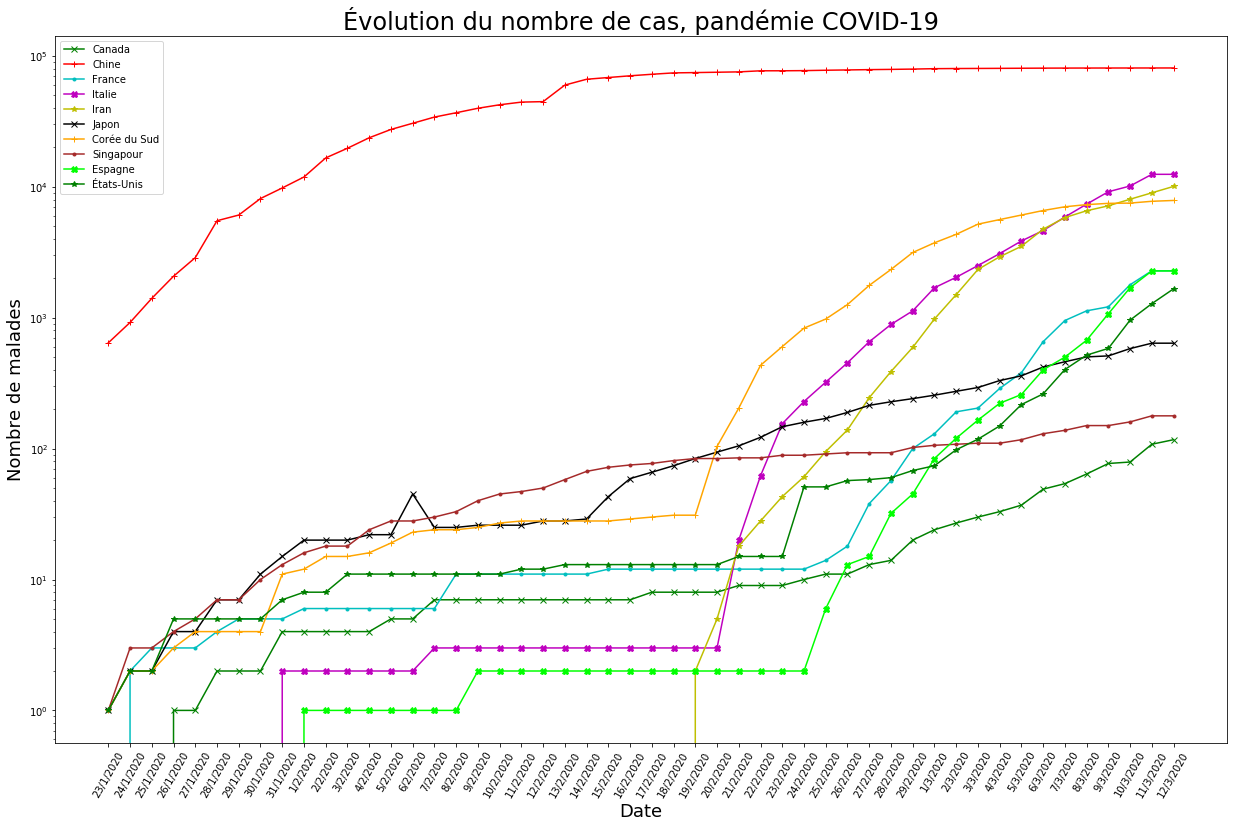

In [66]:
import itertools

nombre_dor = 1.618
hauteur = 13
longueur = int(nombre_dor * hauteur)
fig, ax = plt.subplots(figsize=(longueur,hauteur))
# https://stackoverflow.com/questions/13091649/unique-plot-marker-for-each-plot-in-matplotlib
marqueurs = itertools.cycle(('x', '+', '.', 'X', '*'))
couleurs = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'orange', 'brown', 'lime'))

import matplotlib.colors as pltcol

regions = ['Canada', 'China', 'France', 'Italy', 'Iran', 
           'Japan','Korea, South', 'Singapore', 'Spain', 'US']

etiquettes = {'Canada':'Canada', 'China':'Chine', 'France':'France', 
              'Italy':'Italie', 'Iran':'Iran','Japan':'Japon',
              'Korea, South':'Corée du Sud', 'Singapore':'Singapour', 
              'Spain':'Espagne', 'US':'États-Unis'}
# for region in list(series_chronologiques_COVID19_df['Country/Region'].unique()):
for region in regions:
    if region == "Québec":
        marqueur = "o"
        couleur = "tab:blue"
    else:
        marqueur = next(marqueurs)
        couleur = next(couleurs)
    plt.plot(list(series_chronologiques_COVID19_df.columns[2:]), 
             list(series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']==region].iloc[0,2:]), 
             marker=marqueur, 
             color=couleur, 
             label=etiquettes[region])
plt.legend(loc='best')
xticks(rotation=60)
ax.set_yscale('log')
plt.title(u'Évolution du nombre de cas, pandémie COVID-19',fontsize=24)
plt.xlabel(u'Date',fontsize=18)
_ = plt.ylabel(u'Nombre de malades',fontsize=18)


#### Pour mieux apprécier le phénomène d'accroissement exponentiel

Pour mieux «voir» l'accroissement exponentiel, nous retirons la Chine des pays examinés et nous mettons en commentaire la ligne `ax.set_yscale('log')` qui définit l'échelle logarithmique en ordonnée (i.e. axe vertical).

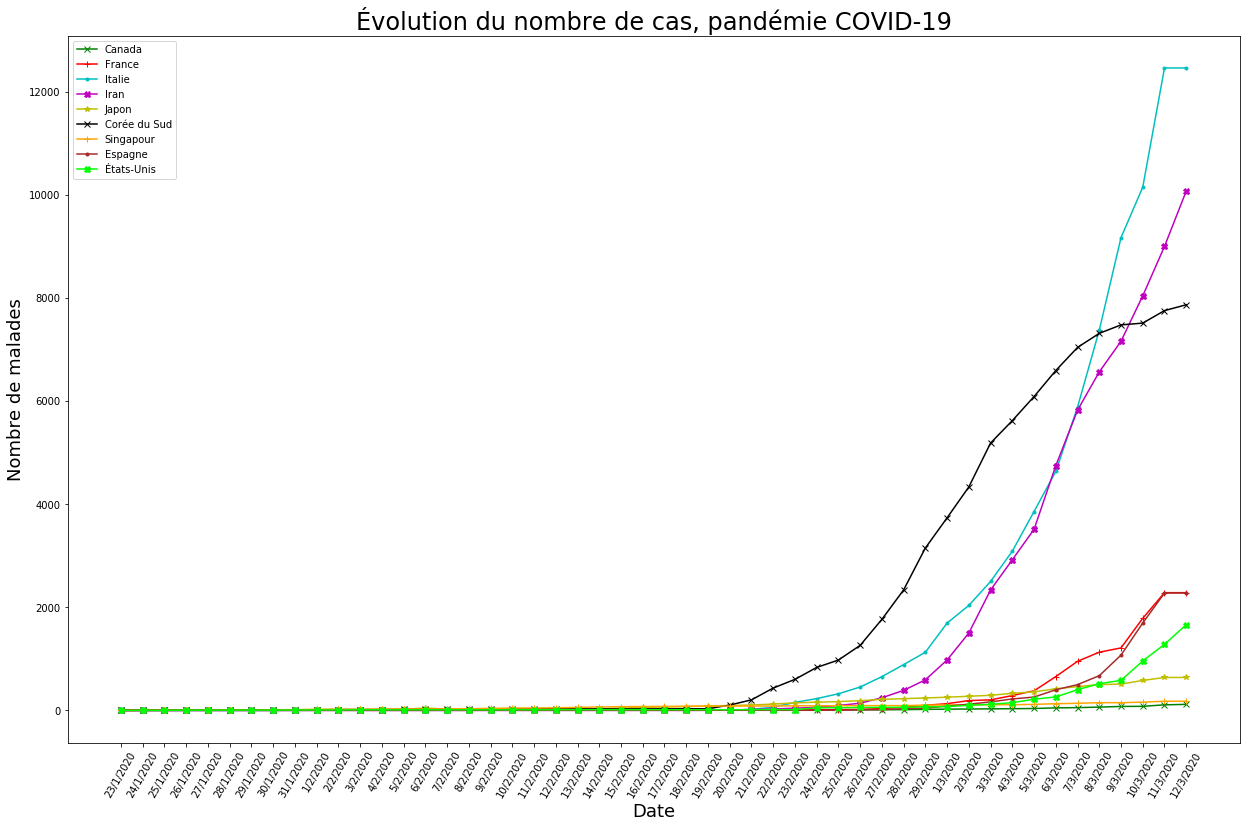

In [67]:
import itertools

nombre_dor = 1.618
hauteur = 13
longueur = int(nombre_dor * hauteur)
fig, ax = plt.subplots(figsize=(longueur,hauteur))
# https://stackoverflow.com/questions/13091649/unique-plot-marker-for-each-plot-in-matplotlib
marqueurs = itertools.cycle(('x', '+', '.', 'X', '*'))
couleurs = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'orange', 'brown', 'lime'))

import matplotlib.colors as pltcol

regions = ['Canada', 'France', 'Italy', 'Iran', 
            'Japan','Korea, South', 'Singapore', 'Spain', 'US']

etiquettes = {'Canada':'Canada', 'China':'Chine', 'France':'France', 
              'Italy':'Italie', 'Iran':'Iran','Japan':'Japon',
              'Korea, South':'Corée du Sud', 'Singapore':'Singapour', 
              'Spain':'Espagne', 'US':'États-Unis'}
# for region in list(series_chronologiques_COVID19_df['Country/Region'].unique()):
for region in regions:
    if region == "Québec":
        marqueur = "o"
        couleur = "tab:blue"
    else:
        marqueur = next(marqueurs)
        couleur = next(couleurs)
    plt.plot(list(series_chronologiques_COVID19_df.columns[2:]), 
             list(series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']==region].iloc[0,2:]), 
             marker=marqueur, 
             color=couleur, 
             label=etiquettes[region])
plt.legend(loc='best')
xticks(rotation=60)
#ax.set_yscale('log')
plt.title(u'Évolution du nombre de cas, pandémie COVID-19',fontsize=24)
plt.xlabel(u'Date',fontsize=18)
_ = plt.ylabel(u'Nombre de malades',fontsize=18)

## Analyse sommaire

On constate que les pays, comme la Chine, le Japon, la Corée du sud et Singapour, qui ont pris des mesures draconiennes de quarantaine et de distanciation sociale, ont réussi à contenir l'accroissement du nombre de cas. 

Au contraire, les pays qui ont tardé à réagir ou manqué de ressources comme l'Italie, l'Iran, les États-Unis, la France ou l'Espagne n'ont pas encore réussi à ralentir l'accroissement du nombre de malades. Pour le moment le Canada et le Québec se situent entre les deux. 